In [10]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
import openpyxl
import akshare as ak
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 5000
pd.options.display.float_format = lambda x: '%.2f' % x

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format='svg'
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [8]:

        price = ak.stock_zh_a_hist(symbol='688981', period='daily', adjust='hfq', 
                                  start_date='20221201', end_date='20250101')
    

        # 数据预处理
        price = price.dropna()
        
        price['EMA12']=price['收盘'].ewm(span=12,adjust=False).mean().round(2)
        price['EMA26']=price['收盘'].ewm(span=26,adjust=False).mean().round(2)
        price['DIF']=(price['EMA12']-price['EMA26']).round(2)
        price['DEA']=price['DIF'].ewm(span=9,adjust=False).mean().round(2)
        price['MACD']=((price['DIF']-price['DEA'])*2).round(2)
        


        
        # 初始化策略参数
        initial_cash = 10000000.0
        tax = 0.00025
        
        # 创建结果DataFrame
        df = pd.DataFrame(columns=['日期', '开盘', '收盘','DIF','DEA','MACD', '可买', '持仓', '交易信号', '总市值', '现金', '策略收益率', '股票收益率'],
                          index=range(len(price)))
        
        # 复制数据
        df[['日期', '开盘', '收盘','DIF','DEA','MACD']] = price[['日期', '开盘', '收盘','DIF','DEA','MACD']]
        df=df.drop(df.index[:22]).reset_index(drop=True)
        # 初始化列
        df['持仓'] = 0
        df['总市值'] = 0.0
        df['现金'] = initial_cash
        df['策略收益率'] = 0.0
        df['股票收益率'] = 0.0
        df['交易信号'] = 0
        df['总资产'] = initial_cash
        df['可买'] = 0
        # 执行策略回测
        for i in range(1, len(df)):
            # 计算可买股数
            df.loc[i, '可买'] = (((df.loc[i-1, '现金'] / df.loc[i, '开盘'])*(1-tax)) // 100) * 100
            
            # 生成交易信号
            if df.loc[i,'DIF']>=df.loc[i,'DEA'] and df.loc[i-1,'DIF']<df.loc[i-1,'DEA']:
                df.loc[i,'交易信号']=1
            if df.loc[i,'DIF']<=df.loc[i,'DEA'] and df.loc[i-1,'DIF']>df.loc[i-1,'DEA']:
                df.loc[i,'交易信号']=-1

                
            # 计算交易成本
            buy = 0
            sell = 0
            
            if i < len(df):
                buy = max(df.loc[i, '开盘'] * df.loc[i, '可买'] * tax, 5) + df.loc[i, '开盘'] * df.loc[i, '可买']
                
            if i in range(len(df)) and df.loc[i-1, '持仓'] > 0:
                sell = df.loc[i, '开盘'] * df.loc[i-1, '持仓'] - max(df.loc[i, '开盘'] * df.loc[i-1, '持仓'] * tax, 5)
                
            # 执行交易
            if df.loc[i-1, '交易信号'] == 1 and df.loc[i-1, '现金'] >= buy and df.loc[i-1, '持仓'] == 0 and i!=len(df)-1:
                df.loc[i, '现金'] = df.loc[i-1, '现金'] - buy
                df.loc[i, '持仓'] = df.loc[i-1, '持仓'] + df.loc[i, '可买']
            elif df.loc[i-1, '交易信号'] == -1 and df.loc[i-1, '持仓'] > 0:
                df.loc[i, '现金'] = df.loc[i-1, '现金'] + sell
                df.loc[i, '持仓'] = 0
            else:
                df.loc[i, '现金'] = df.loc[i-1, '现金']
                df.loc[i, '持仓'] = df.loc[i-1, '持仓']
                
            # 计算总资产和收益率
            df.loc[i, '总市值'] = df.loc[i, '持仓'] * df.loc[i, '收盘']
            df.loc[i, '总资产'] = df.loc[i, '总市值'] + df.loc[i, '现金']
            df.loc[i, '策略收益率'] = (df.loc[i, '总资产'] / initial_cash) - 1
            df.loc[i, '股票收益率'] = (df.loc[i, '收盘'] / df.loc[0, '收盘']) - 1
        
        # 计算最终结果
        if len(df) > 0:
            excess = df.loc[len(df)-1, '策略收益率'] - df.loc[len(df)-1, '股票收益率']
            strategy = df.loc[len(df)-1, '策略收益率']
            stock = df.loc[len(df)-1, '股票收益率']
            

df


,日期,开盘,收盘,DIF,DEA,MACD,可买,持仓,交易信号,总市值,现金,策略收益率,股票收益率,总资产
0,2023-01-03,41.08,41.54,-0.04,0.05,-0.18,0,0,0,0.00,10000000.00,0.00,0.00,10000000.00
1,2023-01-04,41.60,41.92,0.00,0.04,-0.08,240300,0,0,0.00,10000000.00,0.00,0.01,10000000.00
2,2023-01-05,41.80,41.87,0.03,0.03,0.00,239100,0,1,0.00,10000000.00,0.00,0.01,10000000.00
3,2023-01-06,41.87,41.68,0.04,0.04,0.00,238700,238700,0,9949016.00,3132.41,-0.00,0.00,9952148.41
4,2023-01-09,41.80,41.53,0.04,0.04,0.00,0,238700,0,9913211.00,3132.41,-0.01,-0.00,9916343.41
5,2023-01-10,41.60,41.56,0.03,0.04,-0.02,0,238700,0,9920372.00,3132.41,-0.01,0.00,9923504.41
6,2023-01-11,41.48,41.18,0.00,0.03,-0.06,0,238700,0,9829666.00,3132.41,-0.02,-0.01,9832798.41
7,2023-01-12,41.18,40.82,-0.05,0.01,-0.12,0,238700,0,9743734.00,3132.41,-0.03,-0.02,9746866.41
8,2023-01-13,40.93,41.30,-0.05,0.00,-0.10,0,238700,0,9858310.00,3132.41,-0.01,-0.01,9861442.41
9,2023-01-16,41.21,41.92,-0.01,-0.00,-0.02,0,238700,0,10006304.00,3132.41,0.00,0.01,10009436.41


Text(0.5, 0, '时间/月（2022-2024）')

Text(0, 0.5, '收益率')

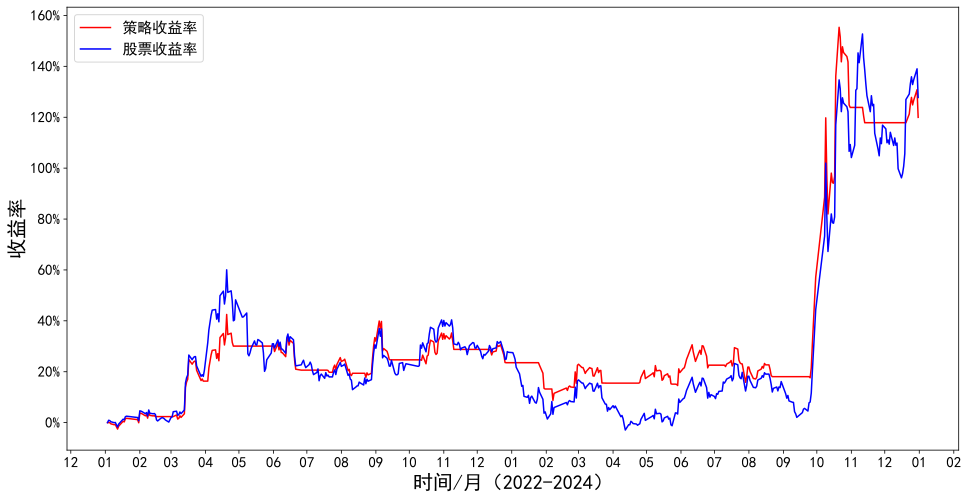

In [9]:
fig,ax1=plt.subplots(figsize=(16,8))
plt.plot(df['日期'],df['策略收益率'],color='r',label='策略收益率')
plt.plot(df['日期'],df['股票收益率'],color='b',label='股票收益率')

plt.xlabel('时间/月（2022-2024）',fontsize=20)
plt.ylabel('收益率',fontsize=20)
plt.legend(fontsize=15)

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=15)

plt.show()

#